In [1]:
using Yao, TensorOperations

## Contracting a Tensor network
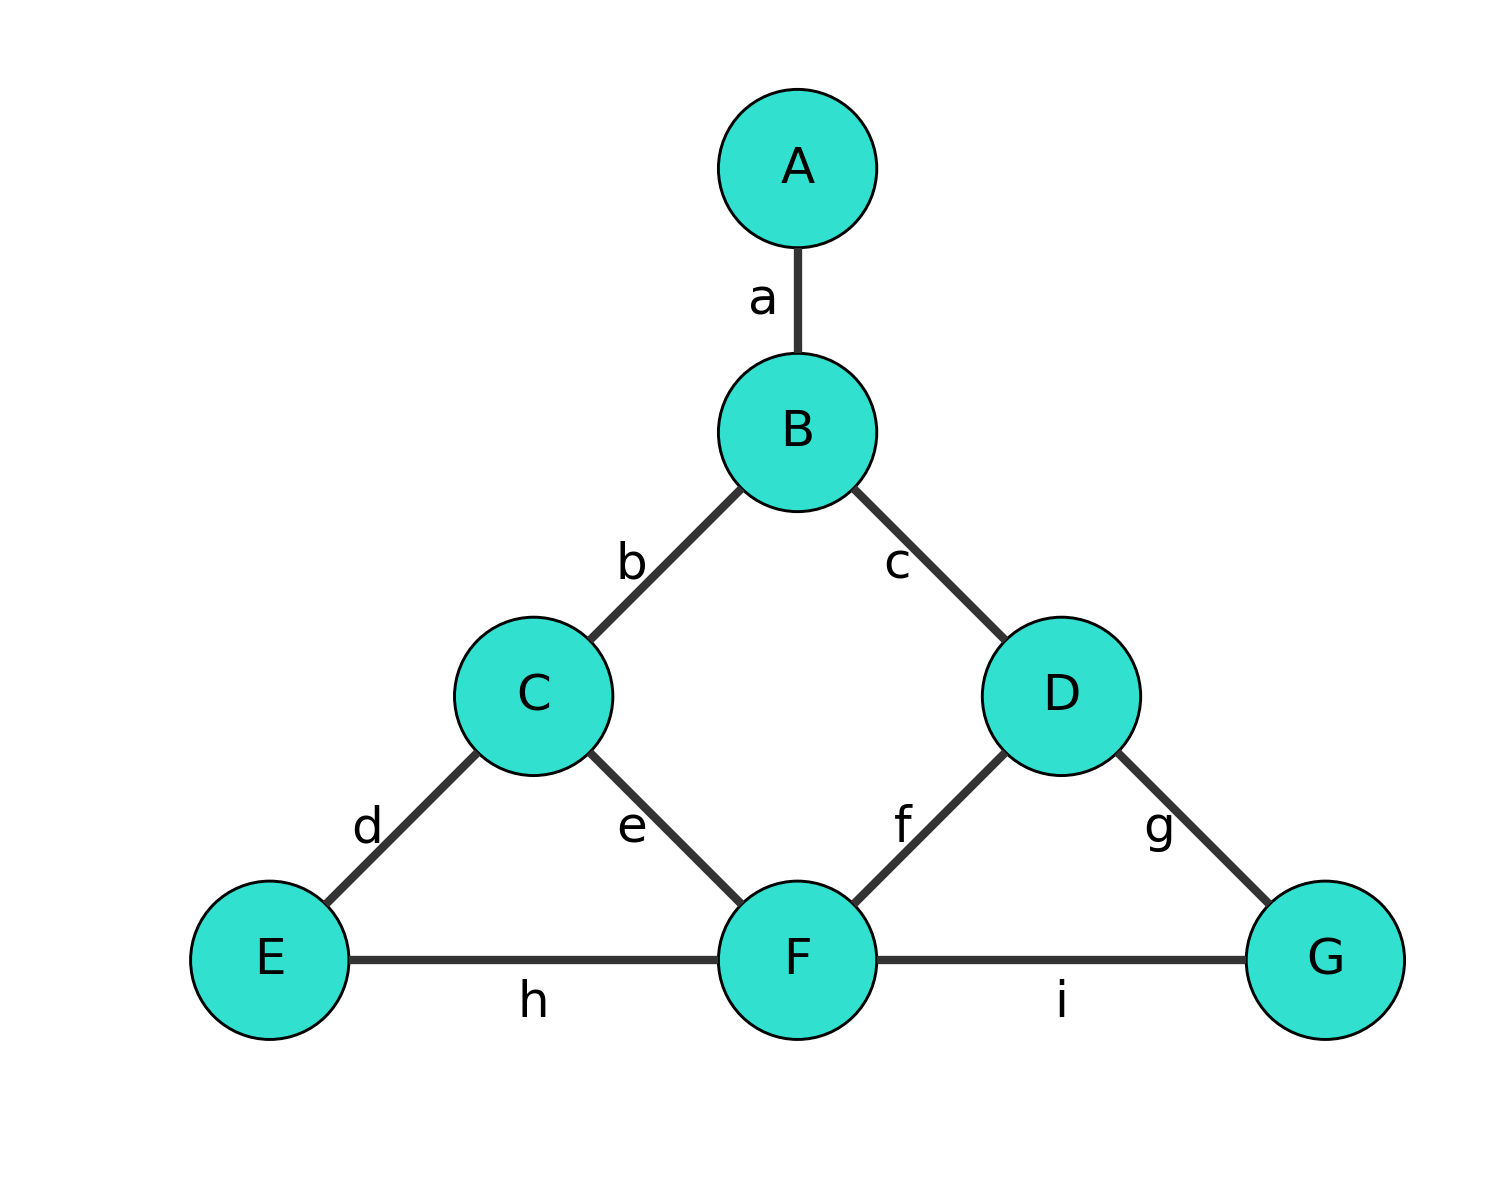

In [2]:
dims = [1, 3, 3, 3, 2, 4, 2]
A, B, C, D, E, F, G = map(nd->randn(fill(20, nd)...), dims)

@tensor begin
    Y1[b, c] := A[a] * B[a,b,c]         # N^3
    Y2[c,d,e] := Y1[b,c] * C[b,d,e]        # N^4
    Y3[d,e,f,g] := Y2[c,d,e] * D[c,f,g]       # N^5
    Y4[d,g,h,i] := Y3[d,e,f,g] * F[e,f,h,i]       # N^6
    Y5[g,i] := Y4[d,g,h,i] * E[d,h]       # N^4
    Y5[g,i] * G[g,i]        # N^2
end

1.2372274789611332e6

# Mapping a QFT circuit to a probability graph

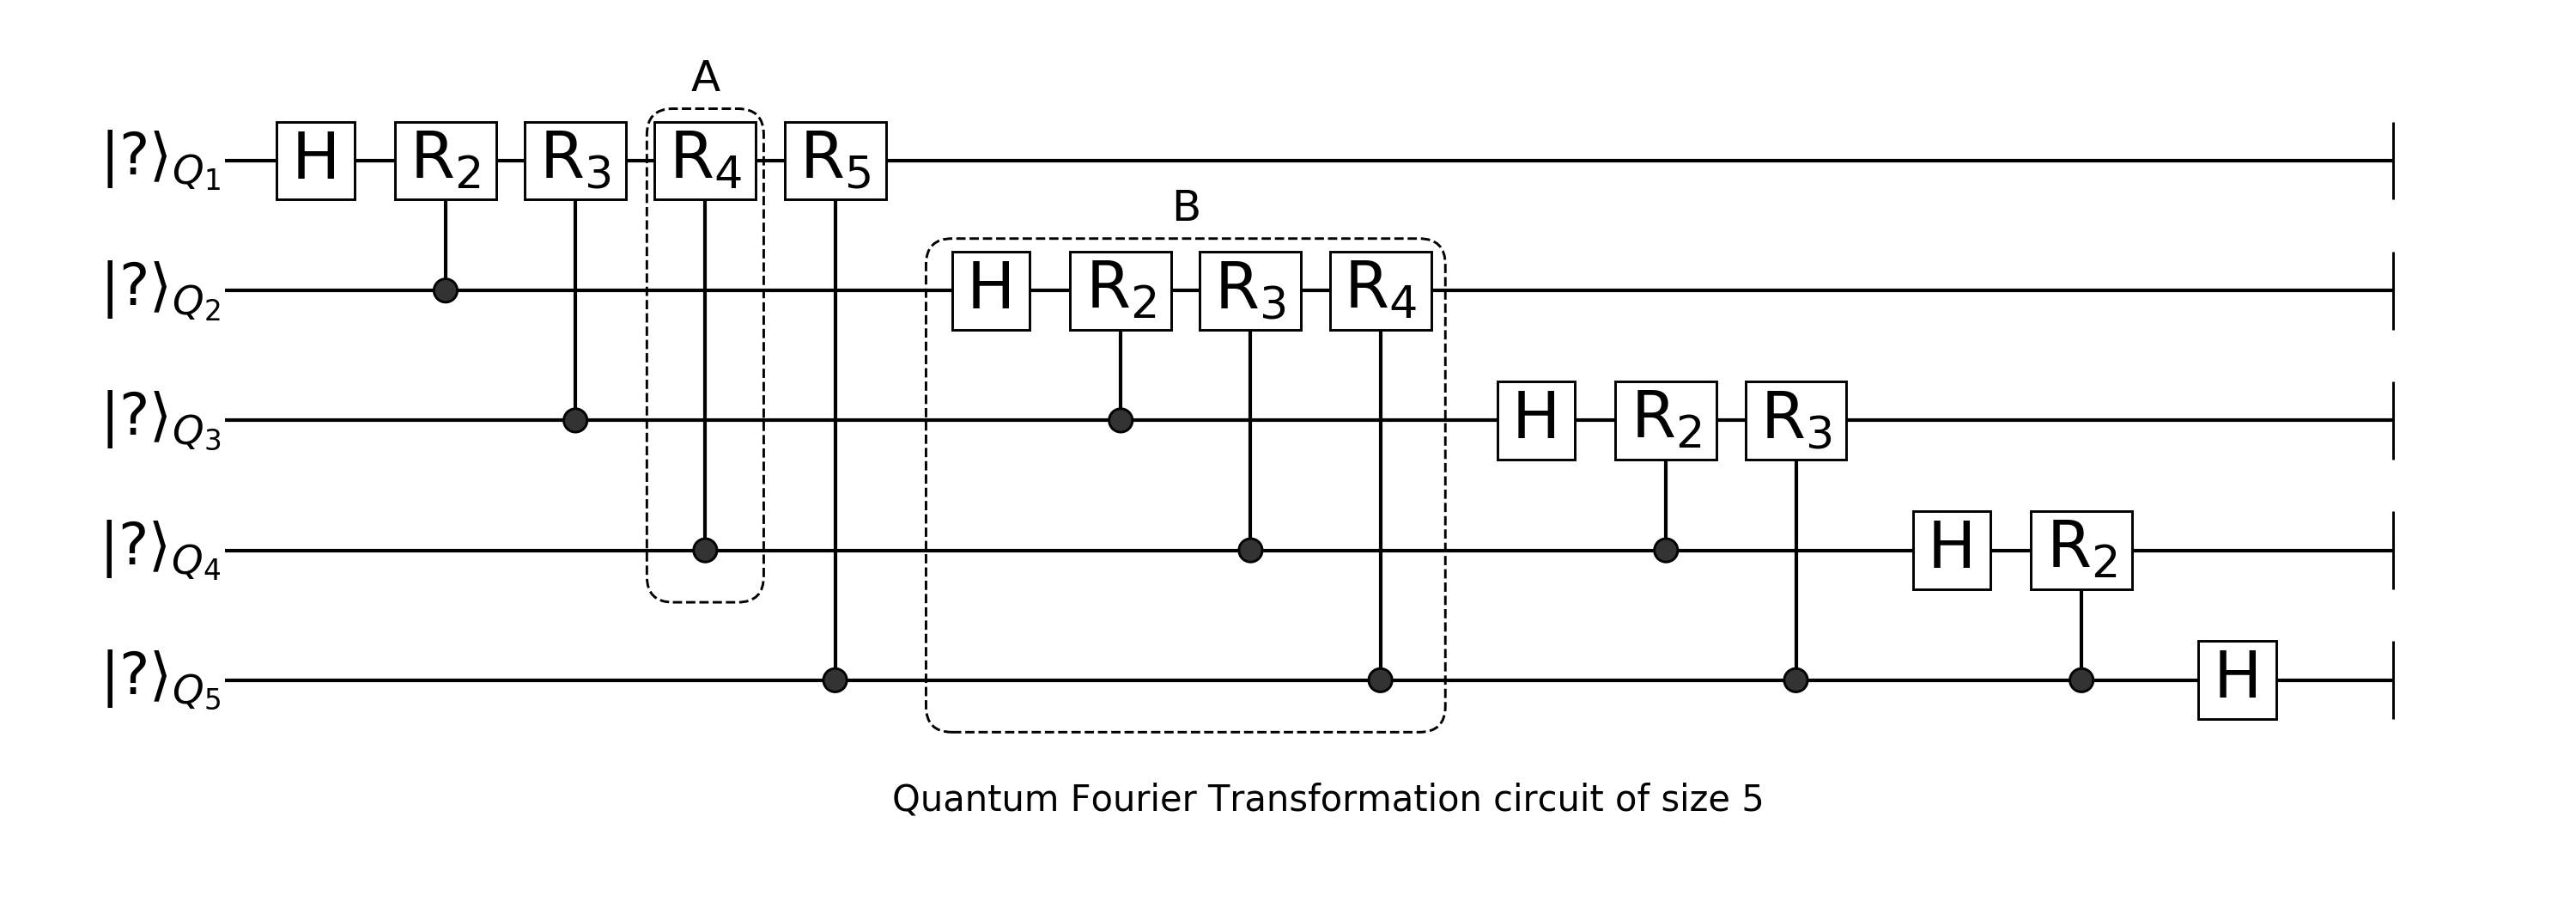

In [16]:
CRk(i::Int, j::Int, k::Int) = control([i, ], j=>shift(2π/(1<<k)))
CRot(n::Int, i::Int) = chain(n, i==j ? kron(i=>H) : CRk(j, i, j-i+1) for j = i:n)
QFTCircuit(n::Int) = chain(n, CRot(n, i) for i = 1:n)

qft = QFTCircuit(5);

### 1. labeling legs in a quantum circuit
* If a gate is diagonal, or a control gate, do not change the label, e.g. CPHASE gate in this example,
* otherwise a asign a new label (like `H` gate in this example)

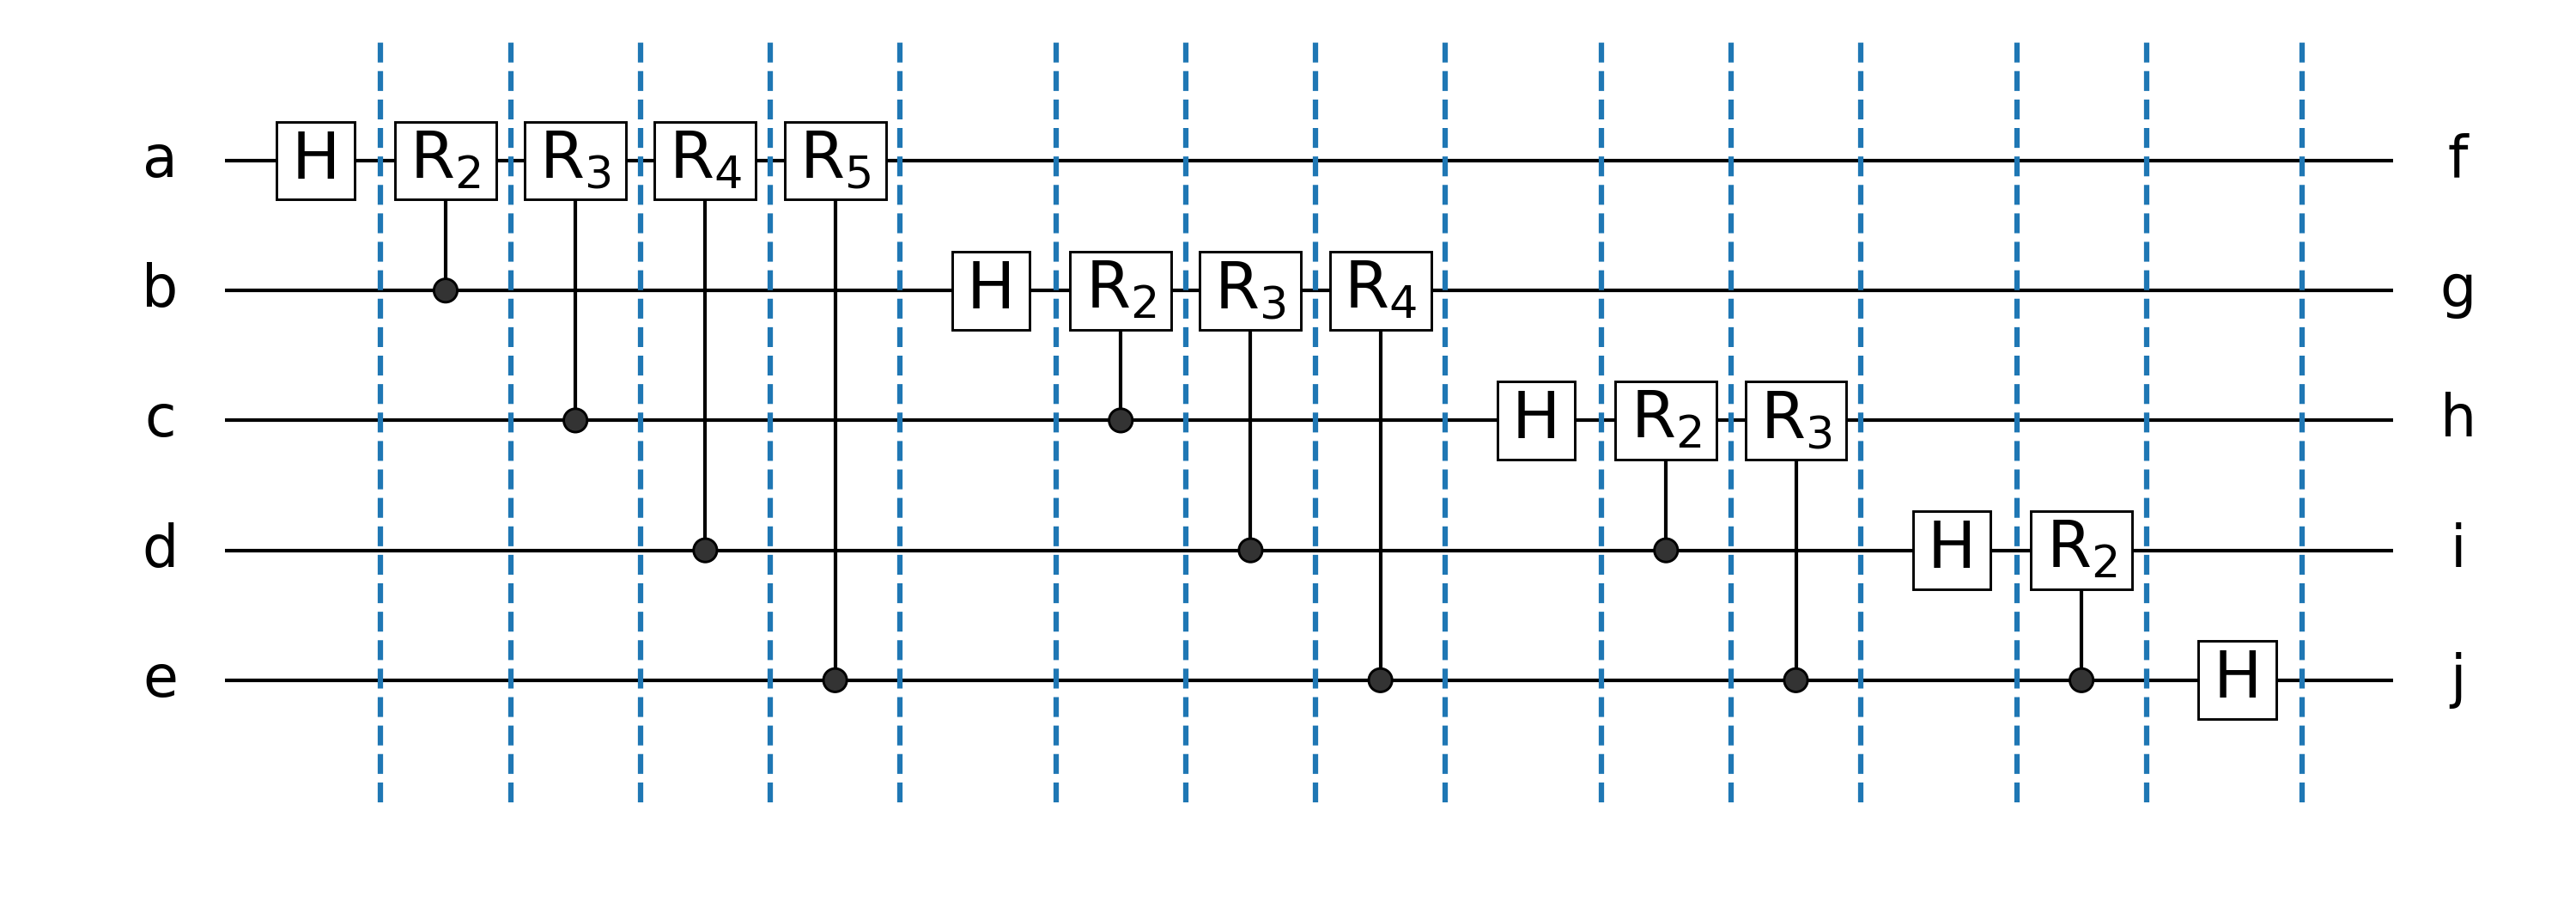

### 2. these labels are nodes in a probability graph

<img src="images/qfttn.png" width="300"/>

We can define a elimination order for this graph, or map it to a tensor network (by introducing $\delta$ notations) and contract it using `TensorOperations.jl`.

In [10]:
TR(k::Int) = [1 1; 1 exp(2im*π/(1<<k))]
function D(dim::Int)
    ts = zeros(fill(2,dim)...)
    ts[1] = 1
    ts[end] = 1
    ts
end
TH = mat(H);

In [11]:
TR2 = TR(2)
TR3 = TR(3)
TR4 = TR(4)
TR5 = TR(5)
δ3 = D(3);
δ4 = D(4);
δ5 = D(5);
δ6 = D(6);

In [12]:
using TensorOperations

In [13]:
reg = rand_state(5);
res = copy(reg) |> qft
ψ = dropdims(reg |> hypercubic, dims=6)

2×2×2×2×2 Array{Complex{Float64},5}:
[:, :, 1, 1, 1] =
  -0.176071-0.0726608im  -0.260603-0.0888657im
 -0.0301986+0.185368im   -0.238037-0.107873im 

[:, :, 2, 1, 1] =
 0.172762-0.00389244im    0.146348+0.0836913im
 0.165943+0.103285im    -0.0640828-0.0503977im

[:, :, 1, 2, 1] =
  0.0697918+0.000757422im  0.0429287+0.154713im 
 -0.0250555+0.149688im      0.183045-0.0463401im

[:, :, 2, 2, 1] =
 0.00032432+0.109026im   -0.129909+0.0417873im
  0.0682505-0.0110009im  -0.148282+0.0232732im

[:, :, 1, 1, 2] =
 -0.101134-0.00979302im  0.0624712-0.161836im
  0.169794-0.159708im     0.191211+0.134413im

[:, :, 2, 1, 2] =
 -0.0253867+0.00635099im  -0.248987+0.111993im
 -0.0553132-0.0536716im    0.043826+0.20316im 

[:, :, 1, 2, 2] =
  0.059548-0.126707im  -0.114875-0.103951im
 -0.091108+0.127783im  -0.270757-0.156469im

[:, :, 2, 2, 2] =
  -0.145703-0.0514439im  0.0620345-0.0384791im
 -0.0664184-0.0668034im   0.100633+0.214655im 

In [14]:
@tensoropt begin
    out[f,g,h,i,j] :=
    ψ[a,b,c,d,e] * 
    TH[a,f1] * TR2[f2,b1] * TR3[f3,c1] * TR4[f4,d1] * TR5[f5,e1] *
    TH[b2,g1] * TR2[g2,c2] * TR3[g3,d2] * TR4[g4,e2] *
    TH[c3,h1] * TR2[h2,d3] * TR3[h3,e3] *
    TH[d4,i1] * TR2[i2,e4] *
    TH[e5,j] *
    δ3[b2,b1,b] *
    δ4[c3,c2,c1,c] *
    δ5[d4,d3,d2,d1,d] *
    δ6[e5,e4,e3,e2,e1,e] *
    δ3[i2,i1,i] *
    δ4[h3,h2,h1,h] *
    δ5[g4,g3,g2,g1,g] *
    δ6[f5,f4,f3,f2,f1,f]
end

2×2×2×2×2 Array{Complex{Float64},5}:
[:, :, 1, 1, 1] =
    -0.115437+0.0601132im  0.0571661+0.22924im  
 -0.000301617-0.0877855im  0.0285023+0.0650688im

[:, :, 2, 1, 1] =
 0.00379363+0.0582227im    0.159786-0.186479im
  0.0267162-0.00502365im  -0.237809-0.12276im 

[:, :, 1, 2, 1] =
   -0.109134+0.0229597im  0.204501+0.0460059im
 -0.00671519+0.0221776im  0.134229-0.235786im 

[:, :, 2, 2, 1] =
  -0.206345-0.0747273im  0.00624298-0.0369912im
 0.00739291-0.128292im    0.0719049-0.1962im   

[:, :, 1, 1, 2] =
 0.0366493+0.106254im  -0.127927+0.0144893im
 -0.168109-0.135717im  0.0436267+0.035253im 

[:, :, 2, 1, 2] =
 -0.435699+0.0349771im  0.0801935+0.244325im 
 0.0718952-0.0268589im  0.0268003-0.0620978im

[:, :, 1, 2, 2] =
 -0.0128536-0.154923im    0.0262584+0.110406im
 -0.0567237-0.00909317im  -0.207715+0.198225im

[:, :, 2, 2, 2] =
 -0.157867-0.171715im    0.0072535+0.0166267im
  -0.10733-0.0262286im  -0.0389537-0.0146979im

In [15]:
statevec(res) ≈ vec(out)

true

# Call for Treewidth algorithm in Julia!